### step 1. 스티커 구하기 or 만들기

In [1]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
import dlib

my_image_path = '/content/images/image.jpeg'
img_bgr = cv2.imread(my_image_path) # OpenCV로 이미지 로드
img_show = img_bgr.copy() # 출력용 이미지 따로 보관
img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)

### step 2. 얼굴 검출 & 랜드마크 검출하기

rectangles[[(175, 76) (265, 166)]]


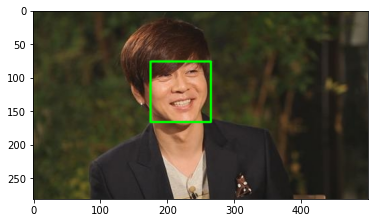

In [2]:
# detector 선언
detector_hog = dlib.get_frontal_face_detector()

# detector_hog를 이용해 얼굴의 bounding box 추출
dlib_rects = detector_hog(img_rgb, 1) # (image, num of image pyramid)

print(dlib_rects)

for dlib_rect in dlib_rects:
  l = dlib_rect.left()
  t = dlib_rect.top()
  r = dlib_rect.right()
  b = dlib_rect.bottom()

  cv2.rectangle(img_show, (l, t), (r, b), (0, 255, 0), 2, lineType=cv2.LINE_AA)

img_show_rgb = cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB)
plt.imshow(img_show_rgb)
plt.show()

In [3]:
!wget http://dlib.net/files/shape_predictor_68_face_landmarks.dat.bz2

--2022-01-11 10:08:51--  http://dlib.net/files/shape_predictor_68_face_landmarks.dat.bz2
Resolving dlib.net (dlib.net)... 107.180.26.78
Connecting to dlib.net (dlib.net)|107.180.26.78|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 64040097 (61M)
Saving to: ‘shape_predictor_68_face_landmarks.dat.bz2’

shape_predictor_68_ 100%[===================>]  61.07M  14.6MB/s    in 6.8s    

2022-01-11 10:09:00 (8.97 MB/s) - ‘shape_predictor_68_face_landmarks.dat.bz2’ saved [64040097/64040097]



In [4]:
mv shape_predictor_68_face_landmarks.dat.bz2 /content/models/

In [5]:
!bzip2 -d /content/models/shape_predictor_68_face_landmarks.dat.bz2

bzip2: Output file /content/models/shape_predictor_68_face_landmarks.dat already exists.


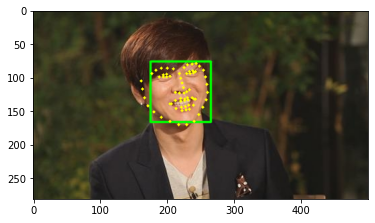

In [6]:
# 저장된 landmark 모델 불러오기
model_path = '/content/models/shape_predictor_68_face_landmarks.dat'
landmakr_predictor = dlib.shape_predictor(model_path)

list_landmarks = []

# 얼굴 영역 박스마다 face landmark를 찾아낸다.
for dlib_rect in dlib_rects:
  points = landmakr_predictor(img_rgb, dlib_rect)

# face landmark 좌료를 지정한다.
  list_points = list(map(lambda p: (p.x, p.y), points.parts()))
  list_landmarks.append(list_points)

for landmark in list_landmarks:
  for point in landmark:
    cv2.circle(img_show, point, 2, (0, 255, 255), -1)

img_show_rgb = cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB)
plt.imshow(img_show_rgb)
plt.show()

### step 3. 스티커 적용 위치 확인하기

In [7]:
# 좌표 확인
for dlib_rect, landmark in zip(dlib_rects, list_landmarks):
  print(landmark[30]) # 코의 index는 30
  x = landmark[30][0]
  y = landmark[30][1] + dlib_rect.height()//2
  w = h = dlib_rect.width()
  print('(x,y) : (%d, %d)'%(x,y))
  print('(w,h) : (%d, %d)'%(w,h))

sticker_path = '/content/images/cat-whiskers.png'
img_sticker = cv2.imread(sticker_path) # 스티커 이미지 로드
img_sticker = cv2.resize(img_sticker, (w, h))
img_sticker = cv2.cvtColor(img_sticker, cv2.COLOR_BGR2RGB)

# top-left 좌표 조정
refined_x = x - w // 2
refined_y = y - h
print('(x,y) : (%d, %d)'%(refined_x, refined_y))

(224, 115)
(x,y) : (224, 160)
(w,h) : (91, 91)
(x,y) : (179, 69)


스티커의 시작점이 얼굴 사진의 영역을 벗어나면 음수로 표현된다. 그런데 opencv 데이터는 numpy ndarray 형태의 데이터를 사용한다. ndarray는 음수 인덱스에 접근할 수 없기 때문에 음수에 대한 예외처리를 해줘야 한다. 따라서 원본 이미지의 범위를 벗어난 스티커 부분을 제거해줘야 한다.  
사실 스티커가 원본 이미지의 범위를 넘어가는 경우는 하나 더 있다. 바로 스티커의 시작점 + 스티커 사진의 크기가 원본 이미지의 크기보다 큰 경우다.

In [8]:
# 예외처리
if refined_x < 0:
  img_sticker = img_sticker[:, -refined_x:]
  refined_x = 0
if refined_y < 0:
  img_sticker = img_sticker[-refined_y:, :]
  refined_y = 0

print('(x,y) : (%d, %d)'%(refined_x, refined_y))

(x,y) : (179, 69)


### step 4. 스티커 적용하기

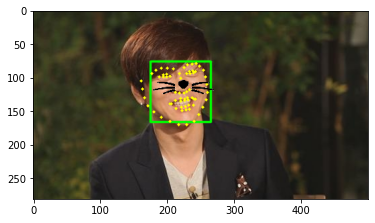

In [9]:
# 길어서 복잡해보이지만 img_show[from:to] 형식이다.
sticker_area = img_show[refined_y:refined_y+img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]]
img_show[refined_y:refined_y+img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]] = \
    np.where(img_sticker==255,sticker_area,img_sticker).astype(np.uint8)

plt.imshow(cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB))
plt.show()

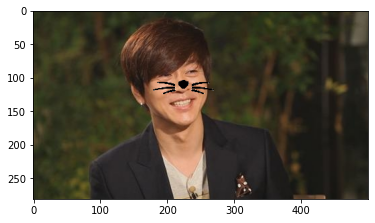

In [10]:
sticker_area = img_bgr[refined_y:refined_y +img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]]
img_bgr[refined_y:refined_y +img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]] = \
    np.where(img_sticker==255,sticker_area,img_sticker).astype(np.uint8)
plt.imshow(cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB))
plt.show()